In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from env import username, host, password

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from prepare import num_distributions, clean_telco_churn, telco_churn_split, prep_telco_churn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics

from math import sqrt
from scipy import stats

In [ ]:
a = 0.05

In [ ]:
df = get_telco_churn_data()
df.tail()

In [ ]:
observed = pd.crosstab(df.churn, df.payment_type)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, payment type and churn are independent, let's keep finding features that are not.")

In [ ]:
sns.countplot(x="payment_type", hue="churn", data=df)

Most payment types are very consistent between the number of people who churn and don't churn. However, electronic check users have a very high churn rate.

In [ ]:
a = 0.05

In [ ]:
observed = pd.crosstab(df.churn, df.paperless_billing)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, paperless billing and churn are not independent")
else:
    print("Fail to reject null hypothesis, paperless billing and churn are independent, let's keep finding features that are not.")

In [ ]:
sns.countplot(x="paperless_billing", hue="churn", data=df)

I am finding that customers who use paperless billing and customers who churn have significant overlap. These groups are not independent. For customers who use paperless billing, a lot of them churn compared to people who don't use automated payments. 

In [ ]:
observed = pd.crosstab(df.churn, df.internet_service_type)
observed

In [ ]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

In [ ]:
if p < a:
    print("Reject null hypothesis, internet type and churn are not independent")
else:
    print("Fail to reject null hypothesis, internet type and churn are independent, let's keep finding features that are not.")

In [ ]:
dsl = df[df.internet_service_type =="DSL"].monthly_charges
fiber_optic = df[df.internet_service_type=="Fiber optic"].monthly_charges

In [ ]:
dsl.hist()

In [ ]:
fiber_optic.hist()

In [ ]:
dsl.var(),fiber_optic.var()

In [ ]:
t,p= stats.ttest_ind(dsl, fiber_optic, equal_var = False)
t, p/2, a

In [ ]:
sns.countplot(x='churn', data = df)

In [ ]:
sns.countplot(x="churn", hue="internet_service_type", data=df)

In [ ]:
sns.countplot(x="internet_service_type", hue="churn", data=df)

In [ ]:
fiber_optic.head()

In [ ]:
#bring in clean data, drop columns we're not using, then split and stratify by churn. 

In [ ]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test

In [2]:
df = get_telco_churn_data()
train, validate, test = prep_telco_churn(df)

In [3]:
x_col = ['fiber_optic', 'electronic_check', 'monthly_charges', 'tenure', 'two_year']
y_col = 'churn'

In [4]:
train.shape, validate.shape, test.shape

((3943, 27), (1691, 27), (1409, 27))

In [5]:
train.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,...,dsl,fiber_optic,no_internet,monthly,one_year,two_year,bank_transfer,credit_card,electronic_check,mailed_check
5707,1,1,0,72,1,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4471,0,1,1,56,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4994,1,0,0,60,1,1,1,1,0,0,...,1,0,0,0,1,0,0,0,1,0
3458,1,1,0,25,1,1,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
3818,0,0,0,20,1,1,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0


In [6]:
X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], validate[y_col]

In [7]:
X_train.head()

,fiber_optic,electronic_check,monthly_charges,tenure,two_year
5707,0,0,25.00,72,1
4471,1,0,88.90,56,0
4994,0,1,71.75,60,0
3458,0,0,69.50,25,0
3818,0,0,59.20,20,0


In [ ]:
y_train.value_counts()

In [8]:
train['baseline_prediction'] = 0 #because I'm predicting more people did NOT churn
round(accuracy_score(train.churn, train.baseline_prediction),2)

0.73

In [9]:
baseline_score = round(accuracy_score(train.churn, train.baseline_prediction),2)

In [ ]:
#accuracy score is 73.4%

# Model Creations

In [40]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [48]:
model1 = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=2)

In [49]:
model1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=15)

In [50]:
print(f'training score: {model1.score(X_train, y_train):.2%}')
print(f'validate score: {model1.score(X_validate, y_validate):.2%}')

training score: 79.53%
validate score: 78.06%


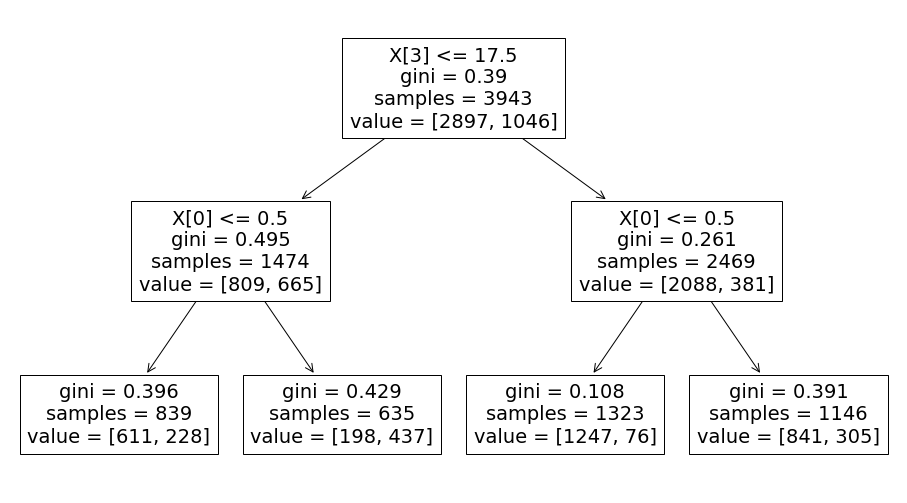

In [51]:
plt.figure(figsize=(16,9))
plot_tree(model1)
plt.show()